# **AI Agent_Memory 관리**

**Memory**
- AI Agent가 이전 상태(state)나 대화 기록을 유지하고 재사용할 수 있도록 하는 기능
    - 유저와 AI 간의 대화를 저장하여 지속적인 맥락을 유지
    - 단순한 세션 메모리 뿐만 아니라, 외부 저장소를 활용하여 장기적인 상태를 저장
- 단기기억과 장기기억 정보를 제어하기 위한 로직을 넣을 수 있음.
    

## **1.환경준비**

### (1) 구글 드라이브

#### 1) 구글 드라이브 폴더 생성
* 새 폴더(LangGraph)를 생성하고
* 제공 받은 파일을 업로드

#### 2) 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### (2) 라이브러리

#### 1) 필요한 라이브러리 설치

In [ ]:
!pip install -U "langchain==0.3.*" "langchain-core==0.3.*" "langchain-community==0.3.*" "langchain-openai" "langgraph==0.2.*" wikipedia -q

#### 2) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import os
import openai

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState, add_messages
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode

### (3) OpenAI API Key 확인

In [ ]:
def load_api_keys(filepath="api_key.txt"):
    with open(filepath, "r") as f:
        for line in f:
            line = line.strip()
            if line and "=" in line:
                key, value = line.split("=", 1)
                os.environ[key.strip()] = value.strip()

path = '/content/drive/MyDrive/LangGraph/'

# API 키 로드 및 환경변수 설정
load_api_keys(path + 'api_key.txt')

⚠️ 아래 코드셀은, 실행해서 key가 제대로 보이는지 확인하고 삭제하세요.

In [ ]:
print(os.environ['OPENAI_API_KEY'][:30])

## 2.기억력 없는 chatbot

### (1) State 정의

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

### (2) Node 정의

In [ ]:
llm = ChatOpenAI(model="gpt-4.1-mini")  # 언어 모델을 gpt-4.1-mini로 설정

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

### (3) 그래프 정의

In [ ]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# compile the graph
graph = builder.compile()

* 그래프 시각화

In [ ]:
graph

### (4) Graph 실행

* 실행1

In [ ]:
result = graph.invoke({"messages": [HumanMessage("안녕? 내 이름은 한기영이야.")]})
for message in result["messages"]:
    message.pretty_print()

* 실행2

In [ ]:
result = graph.invoke({"messages": [HumanMessage("내 이름이 뭐라고?")]})
for message in result["messages"]:
    message.pretty_print()

## 3.Agent에 메모리 추가

**메모리 종류**
- MemorySaver : Short-term Memory
- SqliteSaver : Long-term Memory



### (1) 메모리 준비 : MemorySaver
**MemorySaver**
- Short-term Memory
- LangGraph에서 제공하는 체크포인트(Checkpoint) 저장소
- 그래프 실행 중 생성되는 상태(state)를 자동으로 저장하고 필요 시 복원할 수 있게 해주는 메모리 기반 저장소
- 특징

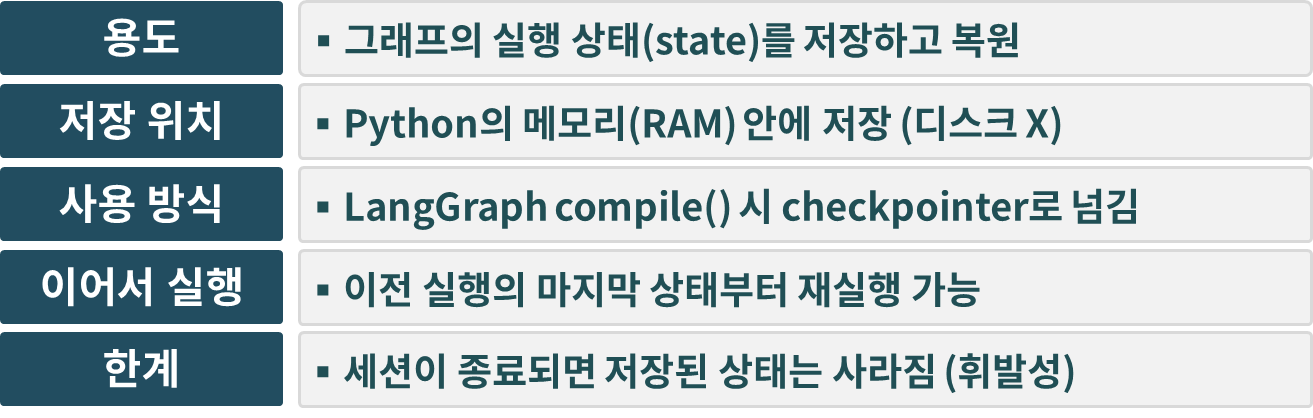   
  

In [ ]:
# 체크포인터를 추가하여 그래프를 컴파일하면 메모리가 활성화됩니다.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver 모듈 가져오기
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화

### (2) 이전 그래프 다시 컴파일

In [ ]:
# 체크포인터와 함께 그래프 컴파일
agent_with_memory = builder.compile(checkpointer=memory)

### (3) 실행

* 스레드 지정

In [ ]:
# 대화 흐름을 구분하기 위한 thread_id 설정
# 각 실행 흐름(예: 특정 대화 스레드)에 대해 고유한 thread_id를 키로 사용하고, 해당 키에 상태 데이터를 저장합니다.
thread_1 = {"configurable": {"thread_id": "1"}}

* 첫번째 메시지

In [ ]:
messages = [HumanMessage(content="3과 4를 더하라")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)

for m in messages['messages']:
    m.pretty_print()

* 두번째 메시지

In [ ]:
messages = [HumanMessage(content="거기에 2를 곱하라.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)

for m in messages['messages']:
    m.pretty_print()

### (4) 새로운 대화

* 새로운 thread id 부여

In [ ]:
# 새로운 스레드 id 부여
thread_2 = {"configurable": {"thread_id": "2"}}

messages = [HumanMessage(content="금리에 대한 정의를 알려줘.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_2)

for m in messages['messages']:
    m.pretty_print()

* 이전 thread id로 다시 대화

In [ ]:
# 첫 번째 입력 메시지를 정의
messages = [HumanMessage(content="마지막으로 계산했던 숫자가 뭐였지?")]

# 그래프 실행 (MemorySaver가 활성화된 그래프 사용)
messages = agent_with_memory.invoke({"messages": messages},thread_1)
# 결과 메시지를 출력
for m in messages['messages']:
    m.pretty_print()

### (5) 실습
* 2번 파일의 실습1에 메모리를 추가해 봅시다.

* LLM을 하나 생성하시오 (ChatOpenAI)
* 다음 도구 3개를 load_tools()를 사용하여 불러오고, ToolNode로 묶으시오
    * llm-math, wikipedia, serpapi
* GPT에게 도구 목록을 알려주기 위해 .bind_tools(tools)를 사용하시오
* 이를 위해 필요한 준비작업을 수행하시오.
    * serpapi api key를 받아 등록
    * 필요한 라이브러리 설치

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt.tool_node import ToolNode
from langchain.agents import load_tools
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing import Literal, Annotated
from typing_extensions import TypedDict
from langchain_core.tools import tool

* 1) 메모리 준비 : MemorySaver

In [ ]:
# 체크포인터를 추가하여 그래프를 컴파일하면 메모리가 활성화됩니다.
from langgraph.checkpoint.memory import MemorySaver  # MemorySaver 모듈 가져오기
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화

* 2) Tool 준비하기

In [ ]:
!pip install google-search-results -q

In [ ]:
from langchain.agents import load_tools

llm = ChatOpenAI(model="gpt-4.1-mini")
tools = load_tools(["llm-math", "wikipedia", "serpapi"], llm=llm) # 일부 툴이 LLM을 내부적으로 쓸 때 필요한 설정


* 3) ToolNode 생성

In [ ]:
tool_node = ToolNode(tools)

# 툴을 쓸 수 있는 LLM
llm_with_tools = llm.bind_tools(tools)  # GPT가 이 툴들을 사용하겠다고 판단할 수 있게 도와주는 설정

* 4) 그래프 만들기

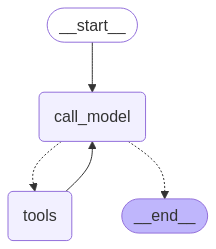

* State

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

* Node 와 분기 함수(conditional edge를 위한 함수)

In [ ]:
# 모델 호출 함수 (GPT 호출)
def call_model(state: State):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 조건 분기 함수: 툴 호출이 필요한가?
def should_continue(state: State) -> Literal["tools", END]:  # 출력은 반드시 "tools" 혹은 END 여야 함.
    messages = state["messages"]
    last_message = messages[-1]  # 가장 최근 message
    if last_message.tool_calls:
        return "tools"
    return END

* 그래프 구성

* 그래프 시각화

* 5) 그래프 사용하기

In [ ]:
# 대화 흐름을 구분하기 위한 thread_id 설정
# 각 실행 흐름(예: 특정 대화 스레드)에 대해 고유한 thread_id를 키로 사용하고, 해당 키에 상태 데이터를 저장합니다.
th_1 = {"configurable": {"thread_id": "1"}}

* 첫번째 메시지

* 두번째 메시지

## 4.메모리 다루기

### (1) 메모리 조회

* thread id 1 에 저장된 메모리 스냅샷

In [ ]:
agent_with_memory.get_state(thread_1).values

In [ ]:
temp = agent_with_memory.get_state(thread_1).values
temp['messages'][-1].content

* thread id 2 에 저장된 메모리 스냅샷

In [ ]:
agent_with_memory.get_state(thread_2).values

*  메모리 삭제
    * 공식적으로 제공되지 않음.
    * Thread id를 새로 시작하거나,
    * memory 인스턴스를 다시 지정

### (2) 최근 메시지 n개만 기억

기억할 메세지 개수 제한하기

* node 정의

In [ ]:
def filter_messages(messages: list):
    # 최근 2개 메시지만 리턴하는 필터 함수 생성
    return messages[-2:]

def chatbot(state: State):
    messages = filter_messages(state["messages"])
    result = llm.invoke(messages)
    return {"messages": [result]}

* 그래프 정의

In [ ]:
# initiate a graph
builder = StateGraph(State)

# add a node
builder.add_node("chatbot", chatbot)

# connect nodes
builder.add_edge(START, "chatbot")
builder.add_edge("chatbot", END)

# 체크포인터와 함께 그래프 컴파일
memory = MemorySaver()  # 메모리 기반 체크포인터 초기화
agent_with_memory = builder.compile(checkpointer=memory)

In [ ]:
config_10 = {"configurable": {"thread_id": "10"}}
messages = [HumanMessage(content="3과 4를 더하라")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="내 이름은 한기영이야.")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="오늘 날씨 어때?")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

messages = [HumanMessage(content="아까 계산했던 값이 얼마?")]
messages = agent_with_memory.invoke({"messages": messages}, thread_1)
messages['messages'][-1].pretty_print()

### (3) [추가] 메시지 요약

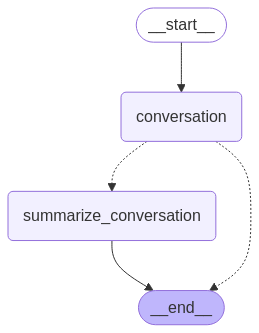

In [ ]:
memory = MemorySaver()

#### 1) State
* MessagesState는 LangGraph가 기본 제공하는 메시지 기반 상태
* 여기에 **summary**라는 새로운 필드를 추가
* state 구조


    {
        "messages": [...],  # 전체 대화 기록
        "summary": "지금까지 요약된 내용"
    }

In [ ]:
class State(MessagesState):
    summary: str

#### 2) 노드와 분기함수

* **대화 노드**

    * 기존 메시지 리스트로 GPT를 호출해서 응답을 받고,
    * 그 응답을 메시지 리스트에 **누적시킬 준비**를 해줌

In [ ]:
def call_model(state: State):
    summary = state.get("summary", "")
    if summary:
        # 요약을 system prompt로 넣어 대화 맥락 유지
        system_message = f"이전 대화 요약: {summary}"
        messages = [SystemMessage(content=system_message)] + state["messages"]
    else:
        messages = state["messages"]

    response = llm.invoke(messages)
    return {"messages": [response]}

* **분기 조건**
    * 메시지가 6개 초과하면 **summarize_conversation** 노드로 분기
    * 그렇지 않으면 바로 **END**

In [ ]:
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    if len(state["messages"]) > 6:
        return "summarize_conversation"
    return END

* **요약 노드**
    * 지금까지 대화 내용으로 요약 생성
    * 메시지 너무 많아지지 않도록 앞쪽 메시지 삭제
    * 요약은 state["summary"]에 저장됨 (누적 요약 느낌)

In [ ]:
from langchain_core.messages import RemoveMessage

def summarize_conversation(state: State):
    summary = state.get("summary", "")   # 이전에 요약된게 있다면, 불러오고, 없으면 ""
    if summary:
        # 이전에 요약이 있다면:
        # 요약 내용을 GPT에게 보여주고
        # “여기에 새 메시지를 반영해서 요약을 이어서 해줘” 요청
        summary_message = (
            f"지금까지 요약된 내용 : {summary}\n\n"
            "여기에 새 메시지를 반영해서 요약을 이어서 해주세요. :" )
    else:
        # 이전 요약이 없다면 (처음 요약) → 대화 전체를 요약해달라고 지시
        summary_message = "대화 내용을 요약해주세요.:"

    # 기존 메시지 목록 끝에 요약 요청 프롬프트를 HumanMessage로 추가
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 전체 메시지 + 요약 요청을 GPT에게 전달해서 요약 결과 받기
    response = llm.invoke(messages)

    # 오래된 메시지를 제거 → 최신 2개만 유지
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

#### 3) 그래프 정의

In [ ]:
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node("summarize_conversation", summarize_conversation)

workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
# 외부 서버를 호출하는 동안 대기시간 초과로 오류가 날 수 있습니다.
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

1. 처음 6개 대화 → END
2. 7번째 입력 → summarize_conversation 실행
    * 요약1 생성
    * 오래된 메시지 삭제
3. 또 6개 쌓이면 → 요약2 생성
    * 기존 요약 + 새 메시지로 “요약 이어 쓰기”
    * 다시 삭제

#### 4) 대화 시작

* 출력 함수 생성

| 부분 | 설명 |
| ---- | ---- |
| update | 그래프 노드 실행 후 변경된 상태 정보 |
| messages | LLM 대화 메시지 리스트 |
| summary | 누적된 요약 정보 (있으면 출력) |
| pretty_print() | 메시지를 보기 좋게 출력하는 LangChain 메서드 |


In [ ]:
def print_update(update):
    for k, v in update.items():
        for m in v["messages"]:
            m.pretty_print()
        if "summary" in v:
            print(v["summary"])

In [ ]:
config = {"configurable": {"thread_id": "10"}}
input_message = HumanMessage(content="안녕? 내 이름은 핑크퐁이야")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="내이름이 뭐라고?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

input_message = HumanMessage(content="나는 FC 바르셀로나를 좋아해!")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

In [ ]:
# 지금까지 요약이 이루어지지 않음
# 목록에 메시지가 6개뿐이기 때문입니다.

values = app.get_state(config).values
values

* 이제 한번 더 이야기하면, 과거 6개 메시지가 요약되고, 삭제 됩니다.

In [ ]:
input_message = HumanMessage(content="나는 그들이 항상 이기는게 좋아.")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

In [ ]:
values = app.get_state(config).values
values

이제 대화를 계속할 수 있습니다! 마지막 두 개의 메시지만 있지만 대화에서 앞서 언급한 내용에 대해 여전히 질문할 수 있습니다(요약했기 때문입니다)

In [ ]:
input_message = HumanMessage(content="참, 내 이름이 뭐라고?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

In [ ]:
input_message = HumanMessage(content="내가 좋아하는 축구팀은?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

In [ ]:
input_message = HumanMessage(content="우리팀과 경쟁하는 팀이 어디야?")
input_message.pretty_print()
for event in app.stream({"messages": [input_message]}, config, stream_mode="updates"):
    print_update(event)

## 5.실습

### (1) 실습1
* 최근 메시지 n개만 기억 : 기억할 메세지 개수 제한하기
    * 기존 코드 수정하기
    * 포함사항 : 시스템 메시지(역할) 지정하기(chatbot 함수에 추가)
    * agent를 만들고 대화하면서 이전 메시지가 제외되는지 확인하기

* node 정의

In [ ]:
def filter_messages(messages: list):


def chatbot(state: State):



* 그래프 정의

In [ ]:
# 테스트 해 봅시다.

### (2) [추가] 실습2
메시지 요약

위 실습1의 메모리를 요약 메모리로 변경해 봅시다.

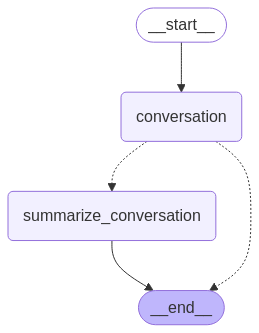

* 1) State
    * MessagesState는 LangGraph가 기본 제공하는 메시지 기반 상태
    * 여기에 **summary**라는 새로운 필드를 추가

* 2) 노드와 분기함수

* **대화 노드**

    * 기존 메시지 리스트로 GPT를 호출해서 응답을 받고,
    * 그 응답을 메시지 리스트에 **누적시킬 준비**를 해줌

* **분기 조건**
    * 메시지가 6개 초과하면 **summarize_conversation** 노드로 분기
    * 그렇지 않으면 바로 **END**

* **요약 노드**
    * 지금까지 대화 내용으로 요약 생성
    * 메시지 너무 많아지지 않도록 앞쪽 메시지 삭제
    * 요약은 state["summary"]에 저장됨 (누적 요약 느낌)

* 3) 그래프 정의

* 4) 대화 시작

* 출력 함수 생성

| 부분 | 설명 |
| ---- | ---- |
| update | 그래프 노드 실행 후 변경된 상태 정보 |
| messages | LLM 대화 메시지 리스트 |
| summary | 누적된 요약 정보 (있으면 출력) |
| pretty_print() | 메시지를 보기 좋게 출력하는 LangChain 메서드 |


* 이제 한번 더 이야기하면, 과거 6개 메시지가 요약되고, 삭제 됩니다.

이제 대화를 계속할 수 있습니다! 마지막 두 개의 메시지만 있지만 대화에서 앞서 언급한 내용에 대해 여전히 질문할 수 있습니다(요약했기 때문입니다)

## 6.체크포인트 저장소(Checkpoint Store)

SQLite DB

**구성**
- checkpoints.sqlite
    - 메인 데이터베이스 파일
    - 모든 데이터의 기본 저장소
- checkpoints.sqlite-wal
    - 쓰기 로그(Write-Ahead Log)
    - 최신 변경사항이 일시적으로 저장됨
- checkpoints.sqlite-shm
    - 공유 메모리 파일 (Shared Memory)



In [ ]:
!pip install langgraph-checkpoint-sqlite -q

In [ ]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

### (1) DB 생성 및 연결

In [ ]:
# check_same_thread=False - 여러 스레드에서 같은 연결 객체를 공유할 수 있도록 허용
# LangGraph나 LangChain은 비동기 처리 또는 멀티 스레드 실행을 사용하는 경우가 많아.

sqlite3_conn = sqlite3.connect('checkpoints.sqlite',check_same_thread=False)
sqlite3_memory_checkpoint = SqliteSaver(sqlite3_conn)

### (2) 메모리 지정

In [ ]:
graph = builder.compile(checkpointer=sqlite3_memory_checkpoint)

### (3) 대화

In [ ]:
graph.invoke(
    {"messages": [HumanMessage("안녕?")]},
    config={"configurable": {"thread_id": 1}}
)

In [ ]:
graph.invoke(
    {"messages": [HumanMessage("내이름은 한기영")]},
    config={"configurable": {"thread_id": 1}}
)